# <center> <b> CLASSICAL MACHINE LEARNING PREDICTION OF ORDER VALUE AND ORDER VOLUME</b> </center> 

* * * * *
This project aims to predict the order value and volume of an ecommerce company for a period of two years.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# load required paackages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import itertools

In [2]:
customers = pd.read_csv("olist_customers_dataset.csv", encoding="utf-8")
geolocation = pd.read_csv("olist_geolocation_dataset.csv", encoding="utf-8")
order_items = pd.read_csv("olist_order_items_dataset.csv", encoding="utf-8")
order_payments = pd.read_csv("olist_order_payments_dataset.csv", encoding="utf-8")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv", encoding="utf-8")
orders = pd.read_csv("olist_orders_dataset.csv", encoding="utf-8")
products = pd.read_csv("olist_products_dataset.csv", encoding="utf-8")
product_category_translation = pd.read_csv("product_category_name_translation.csv", encoding="utf-8")  # English translation for the products
sellers = pd.read_csv("olist_sellers_dataset.csv", encoding="utf-8")

In [3]:
# load regions in Brazil
state_region = pd.read_csv("state_region.csv", encoding="maccentraleurope")


# Objective
Implement a Machine Learning solution that achieves the following:

use classical machine learning approaches
next day order volume and order value by seller
next 7 days order volume and order value by seller
Assumptions:

order_purchase_timestamp feature in the orders dataset indicates when the order took place.
order volume refers to the number of the total orders made by customers. This does not consider the number of items in a given order
order value refers to the value of the total orders made by customers
Note

the price from the order_item dataset is the price of each item in an order not the total price of an order. We would need to aggregate it to get the total price of an order

## Datasets overview and Exploratory Data Analysis

### SELLERS DATASET

In [4]:
sellers.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [5]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [6]:
sellers.tail()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS
3094,9e25199f6ef7e7c347120ff175652c3b,12051,taubate,SP


In [7]:
print("the number of unique sellers is -", sellers.seller_id.nunique())

the number of unique sellers is - 3095


In [8]:
# number of unique city of each seller
sellers["seller_city"].value_counts()

sao paulo         694
curitiba          127
rio de janeiro     96
belo horizonte     68
ribeirao preto     52
                 ... 
barbacena           1
palotina            1
brotas              1
itapui              1
floresta            1
Name: seller_city, Length: 611, dtype: int64

In [9]:
print(
    "the number of unique sellers zip code prefix is -",
    sellers.seller_zip_code_prefix.nunique(),
)

the number of unique sellers zip code prefix is - 2246


In [10]:
print("the number of unique sellers city  prefix is -", sellers.seller_city.nunique())

the number of unique sellers city  prefix is - 611


In [11]:
print("the number of unique sellers state  prefix is -", sellers.seller_state.nunique())

the number of unique sellers state  prefix is - 23


### Brazil Regions


In [12]:
state_region.geolocation_state.nunique()

27

In [13]:
state_region = state_region.drop_duplicates()

In [14]:
state_region.head()

,geolocation_state,State,Capital,Region,Region.1
0,AC,Acre,Rio Branco,N,North
1,AL,Alagoas,Maceiů,NE,NorthEast
2,AP,AmapŠ,MacapŠ,N,North
3,AM,Amazonas,Manaus,N,North
4,BA,Bahia,Salvador,NE,NorthEast


In [15]:
state_region.tail()

,geolocation_state,State,Capital,Region,Region.1
22,RR,Roraima,Boa Vista,N,North
23,SC,Santa Catarina,Florianůpolis,S,South
24,SP,S„o Paulo,S„o Paulo,SD,SouthEast
25,SE,Sergipe,Aracaju,NE,NorthEast
26,TO,Tocantins,Palmas,N,North


In [16]:
state_region.shape

(27, 5)

# Observations:

There 27 states in Brazil. However in the sellers dataset, sellers only come from 23 states. There are 4 states in Brazil we do not have any seller.

### states that do not have sellers¶

In [17]:
state_region[~(state_region.geolocation_state.isin(sellers.seller_state.unique()))]

,geolocation_state,State,Capital,Region,Region.1
1,AL,Alagoas,Maceiů,NE,NorthEast
2,AP,AmapŠ,MacapŠ,N,North
22,RR,Roraima,Boa Vista,N,North
26,TO,Tocantins,Palmas,N,North


In [18]:
# number of states in each region
state_region["Region.1"].value_counts()

NorthEast     9
North         7
SouthEast     4
CenterWest    4
South         3
Name: Region.1, dtype: int64

### Geolocation dataset

In [19]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


### merging the region with the seller table to indicate where the regions where the sellers are located


In [20]:
state_region = state_region.loc[:, ["geolocation_state", "Region.1"]]

sellers_regions = sellers.merge(
    state_region,
    how="inner",
    left_on="seller_state",
    right_on="geolocation_state",
    suffixes=(None, "_y"),
)

sellers_regions = sellers_regions.drop("geolocation_state", axis=1)
sellers_regions.head()


,seller_id,seller_zip_code_prefix,seller_city,seller_state,Region.1
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,SouthEast
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,SouthEast
2,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,SouthEast
3,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,SouthEast
4,1b938a7ec6ac5061a66a3766e0e75f90,16304,penapolis,SP,SouthEast



Replacing the seller_id with a simpler id
A mapping dictionary to replace seller_id with a simple id (seller_simple_id) e.g. seller_1

In [21]:
# create dictionary to map seller_id with simple name (seller_simple_id)
temp_ids_index = np.arange(sellers_regions.seller_id.nunique()) + 1
sellers_simple_ids = np.char.add("seller_", temp_ids_index.astype("str"))

temp_sellers_ids_dict = dict(
    zip(sellers_regions.seller_id.unique(), sellers_simple_ids)
)
print()
print(list(temp_sellers_ids_dict.items())[:5])


[('3442f8959a84dea7ee197c632cb2df15', 'seller_1'), ('d1b65fc7debc3361ea86b5f14c68d2e2', 'seller_2'), ('c0f3eea2e14555b6faeea3dd58c1b1c3', 'seller_3'), ('51a04a8a6bdcb23deccc82b0b80742cf', 'seller_4'), ('1b938a7ec6ac5061a66a3766e0e75f90', 'seller_5')]


In [22]:

sellers_regions["seller_simple_id"] = sellers_regions.seller_id.map(
    temp_sellers_ids_dict
)

In [23]:
sellers_regions.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,Region.1,seller_simple_id
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,SouthEast,seller_1
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,SouthEast,seller_2
2,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,SouthEast,seller_3
3,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,SouthEast,seller_4
4,1b938a7ec6ac5061a66a3766e0e75f90,16304,penapolis,SP,SouthEast,seller_5


### ORDER_ITEMS DATASET

In [24]:
order_items.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [25]:
order_items.head()

# order_items : This dataset includes data about the items purchased within each order.
# order_id : order unique identifier
# order_item_id : sequential number identifying number of items included in the same order

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Examining the number of orders each seller have recorded in the order_items dataset


In [26]:

# number of unique sellers and the orders they had

number_of_orders_per_seller = (
    order_items.groupby(["seller_id"])[["order_id"]]
    .nunique()
    .reset_index()
    .sort_values(by="order_id")
)

number_of_orders_per_seller.columns = ["seller_id", "number_of_orders"]
number_of_orders_per_seller.head()

,seller_id,number_of_orders
1547,7d81e74a4755b552267cd5e081563028,1
1959,a150c540f572d0fb53992264bc5c10b5,1
1953,a1040efe9ff4a6f93c28b0499eada8f5,1
1949,a09a13f18ed27932d08438aa6f12756e,1
1942,9fe7c6641c79970ab48185498f547c09,1


<AxesSubplot:title={'center':'Histogram[Number of Orders]'}, ylabel='Frequency'>

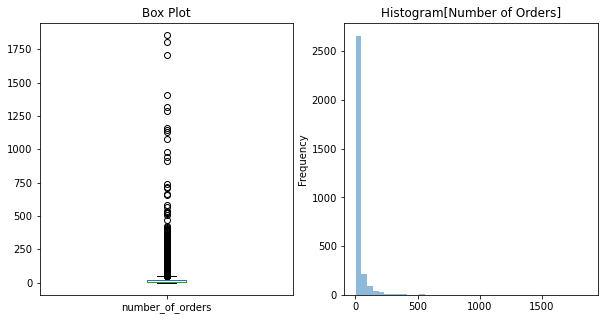

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
number_of_orders_per_seller.number_of_orders.plot.box(ax=ax1, title="Box Plot")
number_of_orders_per_seller.number_of_orders.plot.hist(
    ax=ax2, bins=40, alpha=0.5, title="Histogram[Number of Orders]"
)

In [28]:
number_of_orders_per_seller.number_of_orders.describe()


count    3095.000000
mean       32.313409
std       105.139763
min         1.000000
25%         2.000000
50%         6.000000
75%        21.500000
max      1854.000000
Name: number_of_orders, dtype: float64

### Observations

50% of the sellers have not more than 6 orders in the entire orders dataset.
75% of the sellers have less than 22 orders.
This dataset is too small to train a model that would predict the order volume or value for specific sellers. Especially these sellers with very very little orders. Instead we would reframe the problem to predict what the order volume and value for sellers would be per state and region

### ORDER_PAYMENTS DATASET

In [29]:
order_payments.info()

# order_payments : This dataset includes data about the orders payment options.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [30]:
orders.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [31]:
orders.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Merging orders and order_items datasets¶


In [32]:
orders_merged = order_items.merge(orders, how="left", on="order_id")
orders_merged.head()


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00


In [33]:
orders_merged.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   customer_id                    112650 non-null  object 
 8   order_status                   112650 non-null  object 
 9   order_purchase_timestamp       112650 non-null  object 
 10  order_approved_at              112635 non-null  object 
 11  order_delivered_carrier_date   111456 non-null  object 
 12  order_delivered_customer_date 

In [34]:
minimum_order_date = min(orders_merged.order_purchase_timestamp.astype(np.datetime64))

maximum_order_date = max(orders_merged.order_purchase_timestamp.astype(np.datetime64))

print(
    f" Maximum order date: {maximum_order_date} \n Minimum order date {minimum_order_date}"
)

 Maximum order date: 2018-09-03 09:06:57 
 Minimum order date 2016-09-04 21:15:19


### Products dataset¶


In [35]:
products.head()


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [36]:
print(
    "the number of unqiue products in the orders -",
    orders_merged.product_id.nunique(),
)

# product_id : unique product identifier

the number of unqiue products in the orders - 32951


In [37]:
products.product_id.nunique()


32951

Observation

The product dataset features would not be included in our model features. Because when in production, the product features values would not be available when making predictions. i.e. at the point of predicting the next day order level the product would not be known

### Merging the orders_merged table with sellers¶


In [38]:

# merge sellers with ts_dataset
orders_sellers_region = orders_merged.merge(sellers_regions, how="left", on="seller_id")

In [39]:
orders_sellers_region.head()


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,seller_zip_code_prefix,seller_city,seller_state,Region.1,seller_simple_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,27277,volta redonda,SP,SouthEast,seller_306
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,3471,sao paulo,SP,SouthEast,seller_282
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,37564,borda da mata,MG,SouthEast,seller_2931
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,14403,franca,SP,SouthEast,seller_1210
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,87900,loanda,PR,South,seller_2196


### Replacing product_id, order_id with simplier ids


In [40]:
# create dictionary to replace id with simple name
products_ids_index = np.arange(orders_sellers_region.product_id.nunique()) + 1
products_simple_ids = np.char.add("product_", products_ids_index.astype("str"))

# product ids simple id dictionary - temp_products_ids_dict
temp_products_ids_dict = dict(
    zip(orders_sellers_region.product_id.unique(), products_simple_ids)
)
print(list(temp_products_ids_dict.items())[:5])


# create dictionary to replace id with simple name
orders_ids_index = np.arange(orders_sellers_region.order_id.nunique()) + 1
orders_simple_ids = np.char.add("order_", orders_ids_index.astype("str"))

# orders ids simple id dictionary - temp_orders_ids_dict
temp_orders_ids_dict = dict(
    zip(orders_sellers_region.order_id.unique(), orders_simple_ids)
)
print()
print(list(temp_orders_ids_dict.items())[:5])

[('4244733e06e7ecb4970a6e2683c13e61', 'product_1'), ('e5f2d52b802189ee658865ca93d83a8f', 'product_2'), ('c777355d18b72b67abbeef9df44fd0fd', 'product_3'), ('7634da152a4610f1595efa32f14722fc', 'product_4'), ('ac6c3623068f30de03045865e4e10089', 'product_5')]

[('00010242fe8c5a6d1ba2dd792cb16214', 'order_1'), ('00018f77f2f0320c557190d7a144bdd3', 'order_2'), ('000229ec398224ef6ca0657da4fc703e', 'order_3'), ('00024acbcdf0a6daa1e931b038114c75', 'order_4'), ('00042b26cf59d7ce69dfabb4e55b4fd9', 'order_5')]


In [41]:
# sellers_id has earlier be replaced by a simple id
# olist_dataset['seller_simple_id'] =   olist_dataset['seller_id'].map(temp_sellers_ids_dict)

# replace product_id
orders_sellers_region["product_simple_id"] = orders_sellers_region["product_id"].map(
    temp_products_ids_dict
)

# replace order_id
orders_sellers_region["order_simple_id"] = orders_sellers_region["order_id"].map(
    temp_orders_ids_dict
)

orders_sellers_region.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   customer_id                    112650 non-null  object 
 8   order_status                   112650 non-null  object 
 9   order_purchase_timestamp       112650 non-null  object 
 10  order_approved_at              112635 non-null  object 
 11  order_delivered_carrier_date   111456 non-null  object 
 12  order_delivered_customer_date 

In [42]:
# dictionaries that map the original ids with the simple ones

# temp_sellers_ids_dict
# temp_products_ids_dict
# temp_orders_ids_dict

# drop original ids - product_id, order_id, seller_id
orders_sellers_region = orders_sellers_region.drop(
    ["product_id", "order_id", "seller_id"], axis=1
)

orders_sellers_region.head()

,order_item_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,seller_zip_code_prefix,seller_city,seller_state,Region.1,seller_simple_id,product_simple_id,order_simple_id
0,1,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,27277,volta redonda,SP,SouthEast,seller_306,product_1,order_1
1,1,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,3471,sao paulo,SP,SouthEast,seller_282,product_2,order_2
2,1,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,37564,borda da mata,MG,SouthEast,seller_2931,product_3,order_3
3,1,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,14403,franca,SP,SouthEast,seller_1210,product_4,order_4
4,1,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,87900,loanda,PR,South,seller_2196,product_5,order_5


In [43]:
orders_sellers_region.columns


Index(['order_item_id', 'shipping_limit_date', 'price', 'freight_value',
       'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'Region.1',
       'seller_simple_id', 'product_simple_id', 'order_simple_id'],
      dtype='object')

### Feature Selecting & Engineering
Preliminary decision on features to include to build a model for predicting next day order volume and value
Since we have determined that building a model to predict individual seller order volume and order value would be dificult given that 75% of the sellers have orders less than 22 for the order dataset period (2016-09-04 to 2018-09-03), we would instead a model that predicts the order volume and value per sellers' regions.

It is important to only select features that would exist when the model is deployed in production. The rational is listed below

Details:

only order_purchase_timestamp would be the datetime feature that would be retained. As this is the feature that represents the order date.
order_status would be excluded, we are currently not focusing on the order status, the focus is on orders made

seller_zip_code_prefix would be excluded, this would not be included as there is a likelihood to have a new seller whose zip code would not exist in the training dataset

seller_city would be excluded, the dataset does not contain all the cities in Brazil, their is a likelihood of having a production record that has a seller_city not available in the training and test dataset

seller_state would_be excluded, the dataset does contain all the states in Brazil. It only contains 23 of 27 states. Hence the need to exclude it as a seller may exist in production that does not come from already known states

product_simple_id would be excluded- in production, we would not be aware of what product exist in the seller's order

In [44]:
selected_columns = [
    "order_purchase_timestamp",
    "order_item_id",
    "price",
    "Region.1",
    "order_simple_id",
]

In [45]:
clean_dataset = orders_sellers_region.loc[:, selected_columns]
clean_dataset.head()

,order_purchase_timestamp,order_item_id,price,Region.1,order_simple_id
0,2017-09-13 08:59:02,1,58.90,SouthEast,order_1
1,2017-04-26 10:53:06,1,239.90,SouthEast,order_2
2,2018-01-14 14:33:31,1,199.00,SouthEast,order_3
3,2018-08-08 10:00:35,1,12.99,SouthEast,order_4
4,2017-02-04 13:57:51,1,199.90,South,order_5


In [46]:
clean_dataset.order_item_id.value_counts()

1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: order_item_id, dtype: int64

In [47]:
clean_dataset

,order_purchase_timestamp,order_item_id,price,Region.1,order_simple_id
0,2017-09-13 08:59:02,1,58.90,SouthEast,order_1
1,2017-04-26 10:53:06,1,239.90,SouthEast,order_2
2,2018-01-14 14:33:31,1,199.00,SouthEast,order_3
3,2018-08-08 10:00:35,1,12.99,SouthEast,order_4
4,2017-02-04 13:57:51,1,199.90,South,order_5
...,...,...,...,...,...
112645,2018-04-23 13:57:06,1,299.99,South,order_98662
112646,2018-07-14 10:26:46,1,350.00,SouthEast,order_98663
112647,2017-10-23 17:07:56,1,99.90,South,order_98664
112648,2017-08-14 23:02:59,1,55.99,SouthEast,order_98665


### Observation

Note that some orders have more than one item, some even have as high as over 15 items within an oder.
The price is the price of each item in an order

In [48]:
clean_dataset.groupby("order_simple_id").count()["price"].reset_index().sort_values(
    "price", ascending=False
)

,order_simple_id,price
44600,order_50138,21
61908,order_65716,20
514,order_10460,20
56604,order_60942,15
17317,order_25584,15
...,...,...
34647,order_41180,1
34646,order_4118,1
34645,order_41179,1
34644,order_41178,1


In [49]:
# examining one a particular order with several items
# this particular order has 21 items in it, and the price column represents the price for each item
clean_dataset[clean_dataset.order_simple_id == "order_50138"]

,order_purchase_timestamp,order_item_id,price,Region.1,order_simple_id
57297,2017-07-16 18:19:25,1,1.2,SouthEast,order_50138
57298,2017-07-16 18:19:25,2,1.2,SouthEast,order_50138
57299,2017-07-16 18:19:25,3,1.2,SouthEast,order_50138
57300,2017-07-16 18:19:25,4,1.2,SouthEast,order_50138
57301,2017-07-16 18:19:25,5,1.2,SouthEast,order_50138
57302,2017-07-16 18:19:25,6,1.2,SouthEast,order_50138
57303,2017-07-16 18:19:25,7,1.2,SouthEast,order_50138
57304,2017-07-16 18:19:25,8,1.2,SouthEast,order_50138
57305,2017-07-16 18:19:25,9,1.2,SouthEast,order_50138
57306,2017-07-16 18:19:25,10,1.2,SouthEast,order_50138


### change the order_purchase_timestamp to date only, this would enable us determine the daily sales daily sales per seller¶


In [50]:
# change the datetime to date only

clean_dataset["order_date"] = pd.to_datetime(
    clean_dataset["order_purchase_timestamp"]
).dt.date
clean_dataset = clean_dataset.drop("order_purchase_timestamp", axis=1)

In [51]:
clean_dataset.shape


(112650, 5)

### daily orders and order price grouped by region¶


In [52]:
df_by_region = (
    clean_dataset.groupby(["order_date", "Region.1"], dropna=False)
    .agg(({"order_simple_id": "count", "price": "sum"}))
    .reset_index()
    .sort_index()
)

# rename columes to show what each column actually represent
columns = ["order_date", "region", "order_volume", "order_value"]

df_by_region.columns = columns

df_by_region.tail(20)


,order_date,region,order_volume,order_value
2174,2018-08-22,South,34,3166.15
2175,2018-08-22,SouthEast,179,16978.11
2176,2018-08-23,CenterWest,3,135.68
2177,2018-08-23,NorthEast,2,464.90
2178,2018-08-23,South,16,2518.53
2179,2018-08-23,SouthEast,140,13911.76
2180,2018-08-24,CenterWest,1,99.90
2181,2018-08-24,South,7,591.37
2182,2018-08-24,SouthEast,109,8942.34
2183,2018-08-25,South,4,237.39


### verifying that grouping worked correctly be comparing the output of the df_by_region and df_by_order_value¶


In [53]:
df_by_region[(df_by_region.order_date == pd.to_datetime("2018-08-15"))][
    "order_volume"
].sum()

317

In [54]:
df_by_region[
    (df_by_region.order_date == pd.to_datetime("2018-08-29"))
    & (df_by_region.region == "SouthEast")
]

,order_date,region,order_volume,order_value
2192,2018-08-29,SouthEast,14,1128.04


In [55]:

clean_df = df_by_region.copy()
print("Clean dataset shape :  ", clean_df.shape)

clean_df.sort_values("order_date").head()

Clean dataset shape :   (2194, 4)


,order_date,region,order_volume,order_value
0,2016-09-04,SouthEast,2,72.89
1,2016-09-05,South,1,59.50
2,2016-09-15,South,3,134.97
3,2016-10-02,SouthEast,1,100.00
4,2016-10-03,South,1,29.90


In [56]:
clean_df.tail()


,order_date,region,order_volume,order_value
2189,2018-08-28,South,3,334.50
2190,2018-08-28,SouthEast,42,3339.41
2191,2018-08-29,South,2,418.00
2192,2018-08-29,SouthEast,14,1128.04
2193,2018-09-03,SouthEast,1,145.00


In [57]:
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_date    2194 non-null   object 
 1   region        2194 non-null   object 
 2   order_volume  2194 non-null   int64  
 3   order_value   2194 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 68.7+ KB


In [58]:
# data type conversion
clean_df["order_date"] = pd.to_datetime(clean_df.order_date)
clean_df["region"] = clean_df["region"].astype("category")


clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_date    2194 non-null   datetime64[ns]
 1   region        2194 non-null   category      
 2   order_volume  2194 non-null   int64         
 3   order_value   2194 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 53.9 KB


### Date Feature Engineering¶


In [59]:
# method create new date features from the date feature


def quarter_checker(x):
    if x in [1, 2, 3]:
        return 1
    elif x in [4, 5, 6]:
        return 2
    elif x in [7, 8, 9]:
        return 3
    else:
        return 4


public_holidays_in_brazil = []


def date_feature_engineering(df, column_name, drop_others=False):
    if drop_others:
        columns = list(df.columns)
        columns.remove(column_name)
        df.drop(columns, axis=True, inplace=True)
    df[column_name + "_year"] = df[column_name].dt.year
    df[column_name + "_month"] = df[column_name].dt.month
    df[column_name + "_week"] = df[column_name].dt.week
    df[column_name + "_day"] = df[column_name].dt.day
    df[column_name + "_dayofweek"] = df[column_name].dt.dayofweek

    df[column_name + "_ismonth_start"] = df[column_name + "_day"] == 1

    df[column_name + "_isweekend"] = df[column_name].dt.dayofweek.isin([5, 6])

    df["order_quarter"] = df[column_name].dt.month.apply(lambda x: quarter_checker(x))

    return df

In [60]:
clean_df2 = date_feature_engineering(clean_df, "order_date")
clean_df2.head()

,order_date,region,order_volume,order_value,order_date_year,order_date_month,order_date_week,order_date_day,order_date_dayofweek,order_date_ismonth_start,order_date_isweekend,order_quarter
0,2016-09-04,SouthEast,2,72.89,2016,9,35,4,6,False,True,3
1,2016-09-05,South,1,59.50,2016,9,36,5,0,False,False,3
2,2016-09-15,South,3,134.97,2016,9,37,15,3,False,False,3
3,2016-10-02,SouthEast,1,100.00,2016,10,39,2,6,False,True,4
4,2016-10-03,South,1,29.90,2016,10,40,3,0,False,False,4


In [61]:
# update categorical variable type

clean_df2["order_date_ismonth_start"] = clean_df2.order_date_ismonth_start.astype(
    "category"
)
clean_df2["order_date_isweekend      "] = clean_df2.order_date_isweekend.astype(
    "category"
)

clean_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   order_date                  2194 non-null   datetime64[ns]
 1   region                      2194 non-null   category      
 2   order_volume                2194 non-null   int64         
 3   order_value                 2194 non-null   float64       
 4   order_date_year             2194 non-null   int64         
 5   order_date_month            2194 non-null   int64         
 6   order_date_week             2194 non-null   int64         
 7   order_date_day              2194 non-null   int64         
 8   order_date_dayofweek        2194 non-null   int64         
 9   order_date_ismonth_start    2194 non-null   category      
 10  order_date_isweekend        2194 non-null   bool          
 11  order_quarter               2194 non-null   int64       

### Visualization of date features and region on order value and volume¶


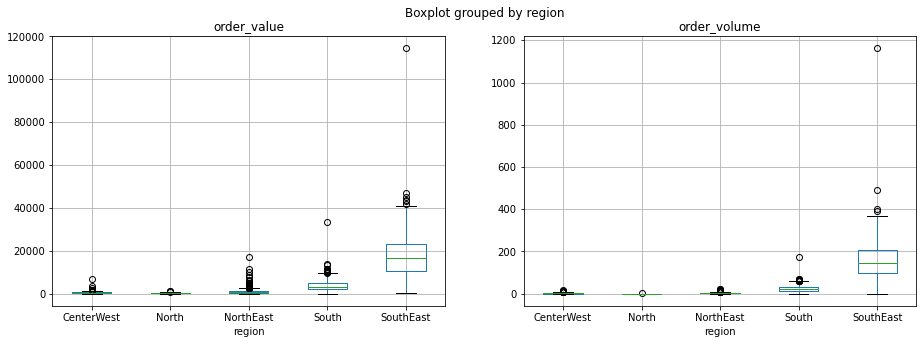

In [62]:
# By Region

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

clean_df2.boxplot(["order_value"], by="region", figsize=(15, 5), ax=axes[0])

clean_df2.boxplot(["order_volume"], by="region", figsize=(15, 5), ax=axes[1])

plt.show()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(1, 0, '(2016, CenterWest)'),
  Text(2, 0, '(2016, North)'),
  Text(3, 0, '(2016, NorthEast)'),
  Text(4, 0, '(2016, South)'),
  Text(5, 0, '(2016, SouthEast)'),
  Text(6, 0, '(2017, CenterWest)'),
  Text(7, 0, '(2017, North)'),
  Text(8, 0, '(2017, NorthEast)'),
  Text(9, 0, '(2017, South)'),
  Text(10, 0, '(2017, SouthEast)'),
  Text(11, 0, '(2018, CenterWest)'),
  Text(12, 0, '(2018, North)'),
  Text(13, 0, '(2018, NorthEast)'),
  Text(14, 0, '(2018, South)'),
  Text(15, 0, '(2018, SouthEast)')])

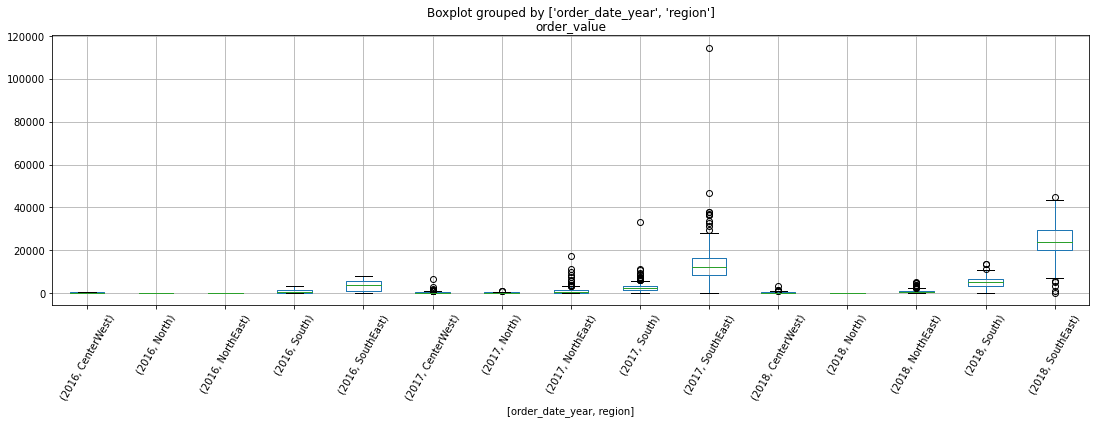

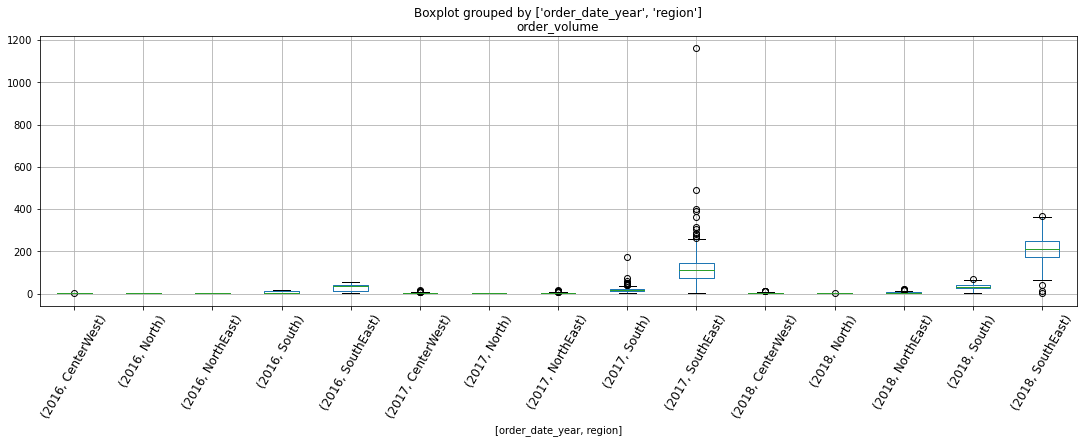

In [63]:
# By Order Date Year and Region'

clean_df2.boxplot(
    ["order_value"],
    by=[
        "order_date_year",
        "region",
    ],
    figsize=(18, 5),
)
plt.xticks(
    rotation=60,
)
clean_df2.boxplot(["order_volume"], by=["order_date_year", "region"], figsize=(18, 5))
plt.xticks(rotation=60, fontsize=12)

(array([1, 2, 3, 4]),
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

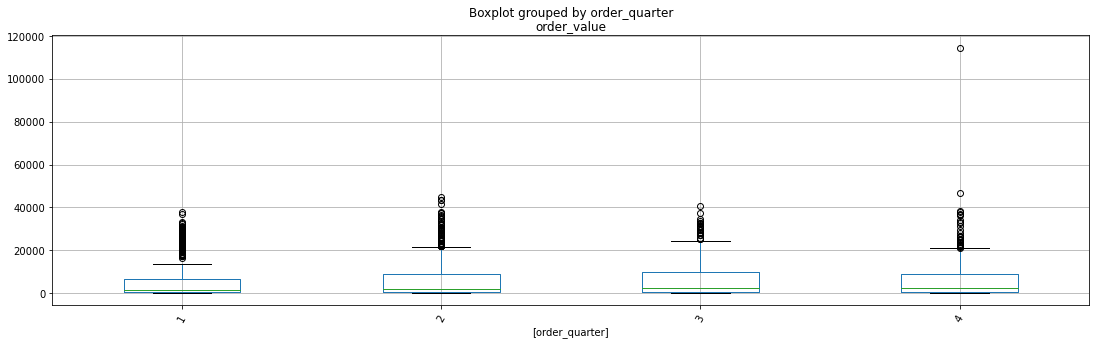

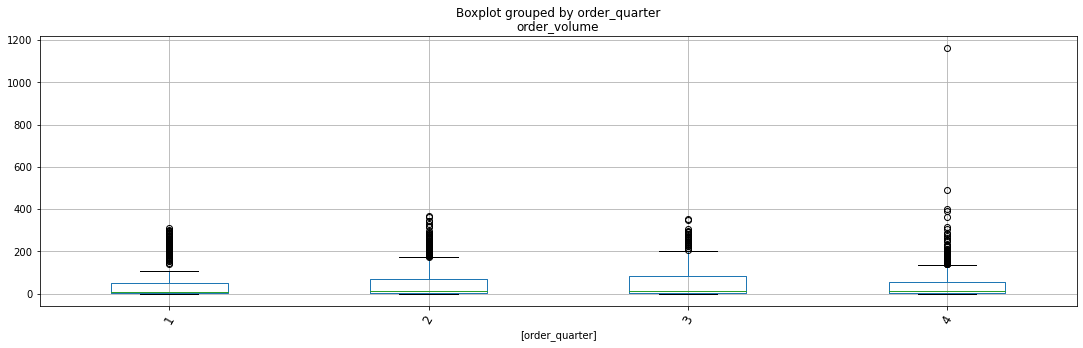

In [64]:
# By Order Quarter

clean_df2.boxplot(
    ["order_value"],
    by=[
        "order_quarter",
    ],
    figsize=(18, 5),
)
plt.xticks(
    rotation=60,
)
clean_df2.boxplot(["order_volume"], by=["order_quarter"], figsize=(18, 5))
plt.xticks(rotation=60, fontsize=12)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

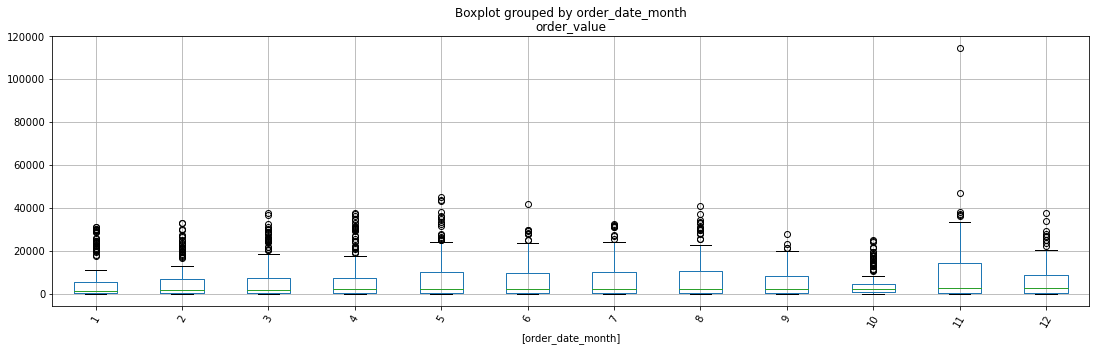

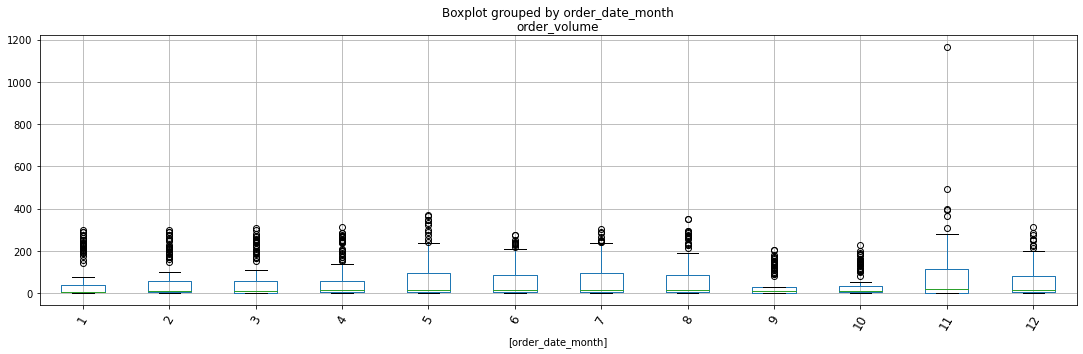

In [65]:
# By Order Month

clean_df2.boxplot(
    ["order_value"],
    by=[
        "order_date_month",
    ],
    figsize=(18, 5),
)
plt.xticks(
    rotation=60,
)
clean_df2.boxplot(["order_volume"], by=["order_date_month"], figsize=(18, 5))
plt.xticks(rotation=60, fontsize=12)

(array([1, 2, 3, 4, 5, 6, 7]),
 [Text(1, 0, '0'),
  Text(2, 0, '1'),
  Text(3, 0, '2'),
  Text(4, 0, '3'),
  Text(5, 0, '4'),
  Text(6, 0, '5'),
  Text(7, 0, '6')])

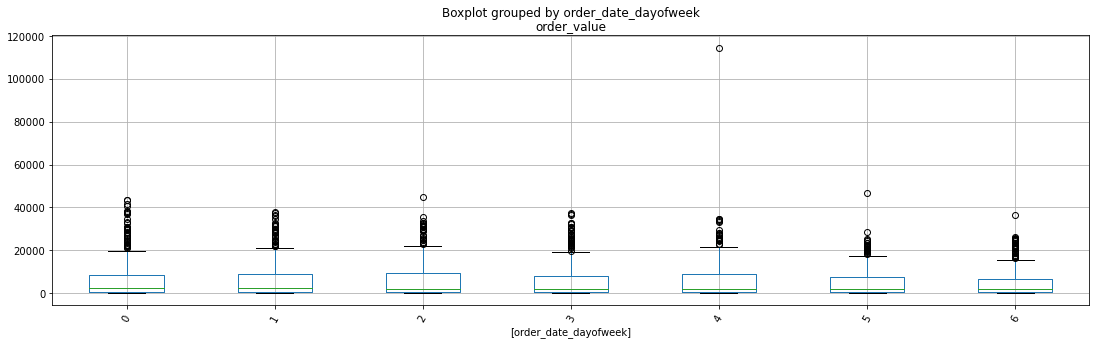

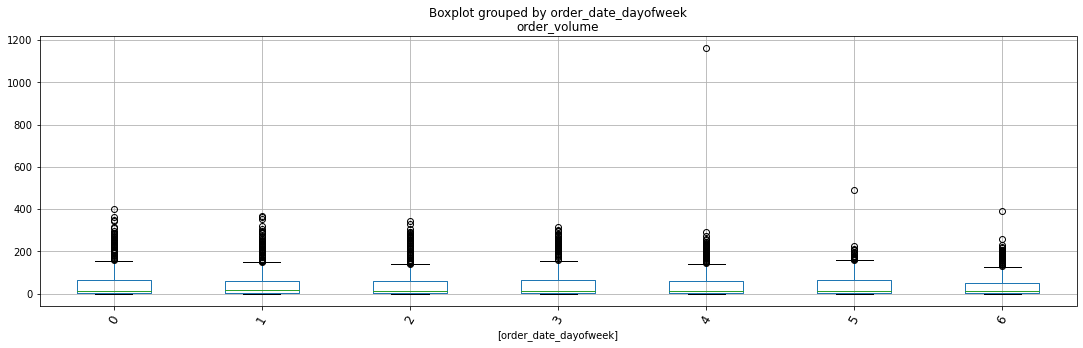

In [66]:
# By Order day of the week

clean_df2.boxplot(
    ["order_value"],
    by=[
        "order_date_dayofweek",
    ],
    figsize=(18, 5),
)
plt.xticks(
    rotation=60,
)
clean_df2.boxplot(["order_volume"], by=["order_date_dayofweek"], figsize=(18, 5))
plt.xticks(rotation=60, fontsize=12)

## MODELLING

In [67]:
#Data Preparation¶


In [68]:
clean_df2.columns


Index(['order_date', 'region', 'order_volume', 'order_value',
       'order_date_year', 'order_date_month', 'order_date_week',
       'order_date_day', 'order_date_dayofweek', 'order_date_ismonth_start',
       'order_date_isweekend', 'order_quarter', 'order_date_isweekend      '],
      dtype='object')

In [69]:
clean_df2 = clean_df2.loc[
    :,
    [
        "order_date",
        "order_date_year",
        "order_date_month",
        "order_date_week",
        "order_date_day",
        "order_date_dayofweek",
        "order_date_ismonth_start",
        "order_date_isweekend",
        "order_quarter",
        "region",
        "order_value",
        "order_volume",
    ],
]

clean_df2.head()

,order_date,order_date_year,order_date_month,order_date_week,order_date_day,order_date_dayofweek,order_date_ismonth_start,order_date_isweekend,order_quarter,region,order_value,order_volume
0,2016-09-04,2016,9,35,4,6,False,True,3,SouthEast,72.89,2
1,2016-09-05,2016,9,36,5,0,False,False,3,South,59.50,1
2,2016-09-15,2016,9,37,15,3,False,False,3,South,134.97,3
3,2016-10-02,2016,10,39,2,6,False,True,4,SouthEast,100.00,1
4,2016-10-03,2016,10,40,3,0,False,False,4,South,29.90,1


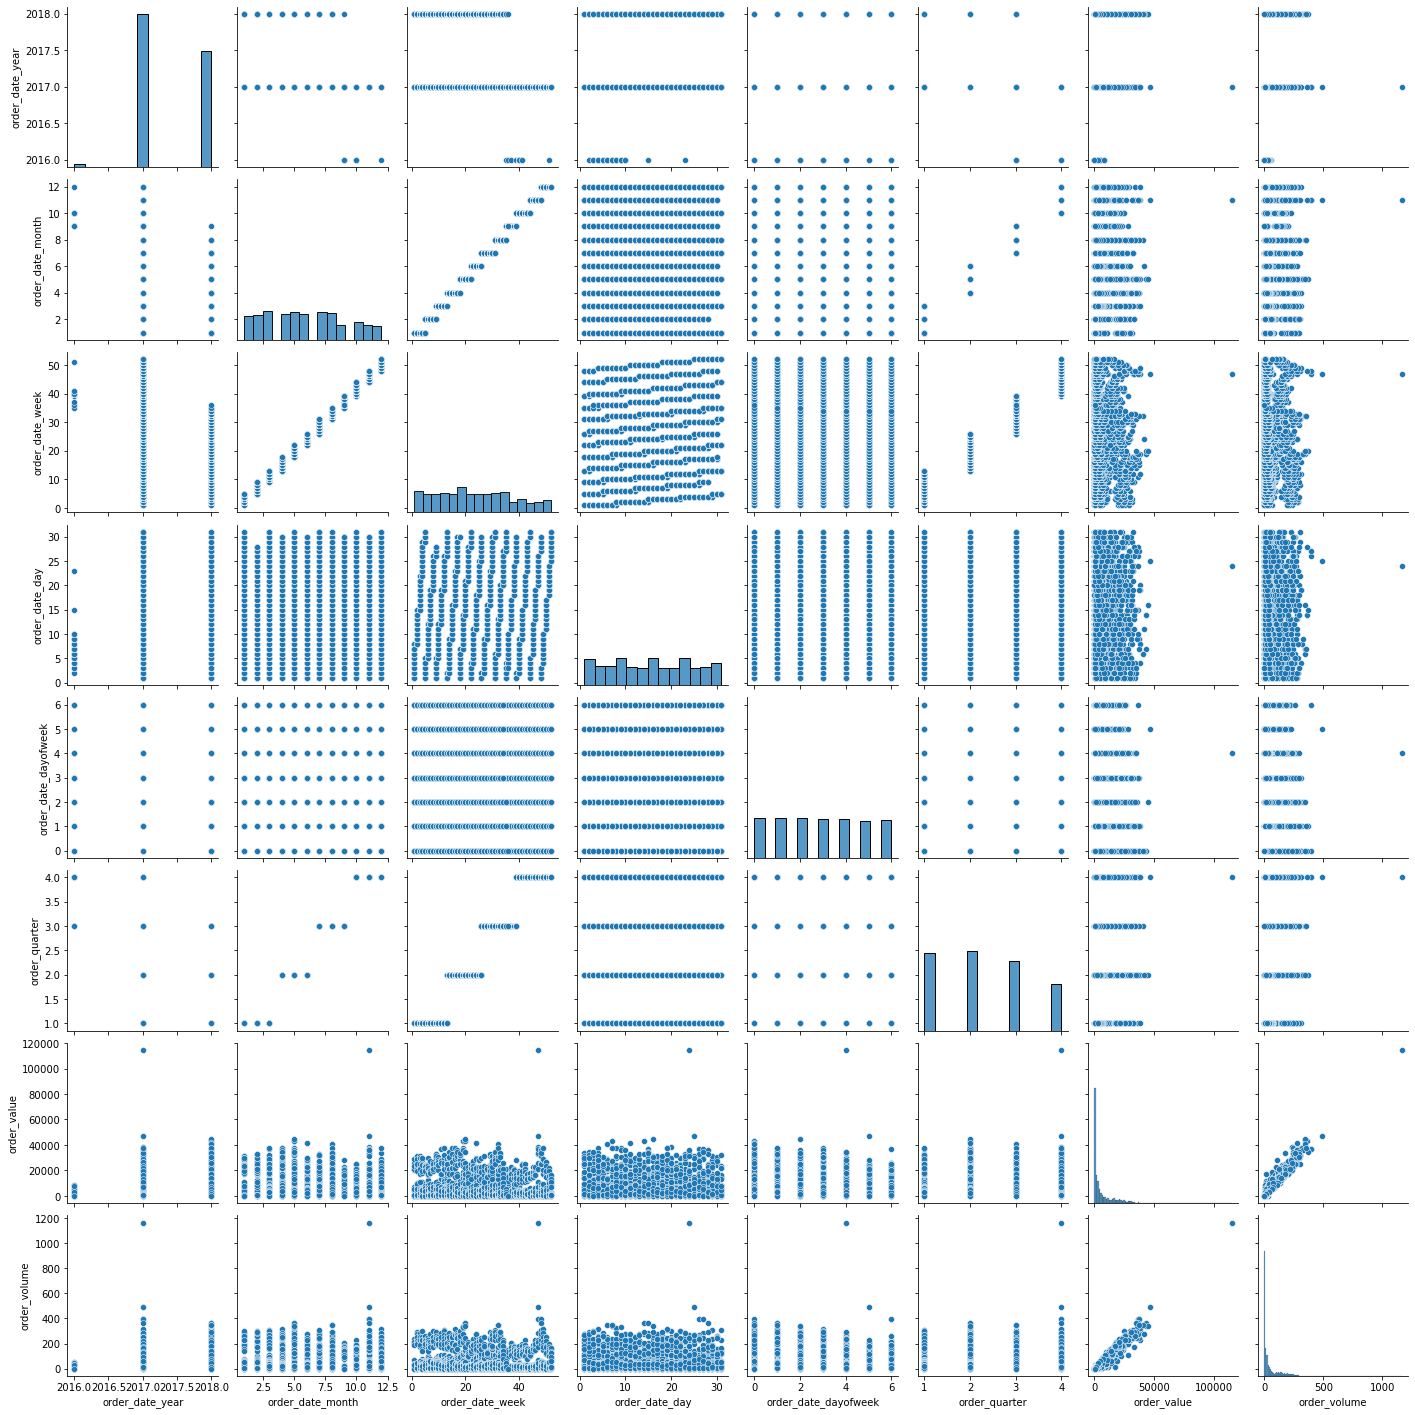

In [70]:

# # visualizing the relionship that exist between the features
import seaborn as sns

sns.pairplot( clean_df2.select_dtypes("number"),)

<AxesSubplot:>

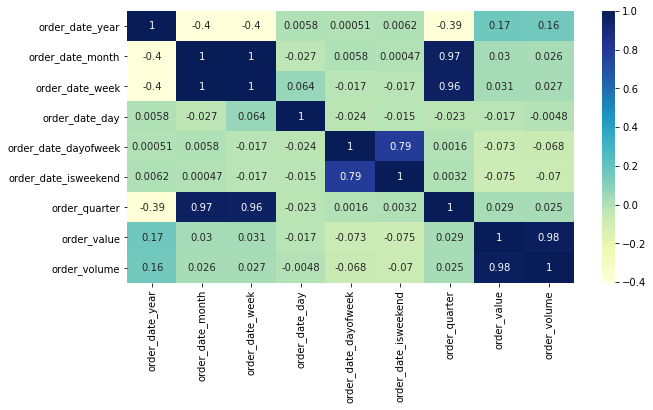

In [72]:
## correlation between variables
plt.figure(figsize=(10, 5))
sns.heatmap(clean_df2.corr(), annot=True, cmap="YlGnBu")


Split data into training and test
the test data would commence from order_date of 2018-08-05 to enable us compare the result effectively with the SARIMA model

In [75]:
clean_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_date                2194 non-null   datetime64[ns]
 1   order_date_year           2194 non-null   int64         
 2   order_date_month          2194 non-null   int64         
 3   order_date_week           2194 non-null   int64         
 4   order_date_day            2194 non-null   int64         
 5   order_date_dayofweek      2194 non-null   int64         
 6   order_date_ismonth_start  2194 non-null   category      
 7   order_date_isweekend      2194 non-null   bool          
 8   order_quarter             2194 non-null   int64         
 9   region                    2194 non-null   category      
 10  order_value               2194 non-null   float64       
 11  order_volume              2194 non-null   int64         
dtypes: bool(1), category

In [76]:
training = clean_df2[clean_df2.order_date < " 2018-08-05"]
test = clean_df2[clean_df2.order_date >= " 2018-08-05"]

In [77]:
training.tail()


,order_date,order_date_year,order_date_month,order_date_week,order_date_day,order_date_dayofweek,order_date_ismonth_start,order_date_isweekend,order_quarter,region,order_value,order_volume
2099,2018-08-03,2018,8,31,3,4,False,False,3,SouthEast,34444.73,291
2100,2018-08-04,2018,8,31,4,5,False,True,3,CenterWest,283.90,2
2101,2018-08-04,2018,8,31,4,5,False,True,3,NorthEast,825.97,7
2102,2018-08-04,2018,8,31,4,5,False,True,3,South,5942.14,38
2103,2018-08-04,2018,8,31,4,5,False,True,3,SouthEast,28459.95,227


In [78]:
test.head()


,order_date,order_date_year,order_date_month,order_date_week,order_date_day,order_date_dayofweek,order_date_ismonth_start,order_date_isweekend,order_quarter,region,order_value,order_volume
2104,2018-08-05,2018,8,31,5,6,False,True,3,CenterWest,406.30,5
2105,2018-08-05,2018,8,31,5,6,False,True,3,NorthEast,886.68,7
2106,2018-08-05,2018,8,31,5,6,False,True,3,South,8887.76,43
2107,2018-08-05,2018,8,31,5,6,False,True,3,SouthEast,25403.02,257
2108,2018-08-06,2018,8,32,6,0,False,False,3,CenterWest,205.98,5


In [79]:
training.columns


Index(['order_date', 'order_date_year', 'order_date_month', 'order_date_week',
       'order_date_day', 'order_date_dayofweek', 'order_date_ismonth_start',
       'order_date_isweekend', 'order_quarter', 'region', 'order_value',
       'order_volume'],
      dtype='object')

In [80]:
# retrieve features and targets from dataset
def retrieve_features_n_target(dataset):
    # selected features
    features_columns = [
        "order_date_month",
        "order_date_week",
        "order_date_day",
        "order_date_dayofweek",
        "order_date_ismonth_start",
        "order_date_isweekend",
        "order_quarter",
        "region",
    ]
    # features
    X = dataset[features_columns]

    # targets
    y_value = np.ravel(dataset[["order_value"]])
    y_volume = np.ravel(dataset[["order_volume"]])

    return X, y_value, y_volume

In [81]:
training_X, training_y_value, training_y_volume = retrieve_features_n_target(training)


In [82]:
training_X.head()


,order_date_month,order_date_week,order_date_day,order_date_dayofweek,order_date_ismonth_start,order_date_isweekend,order_quarter,region
0,9,35,4,6,False,True,3,SouthEast
1,9,36,5,0,False,False,3,South
2,9,37,15,3,False,False,3,South
3,10,39,2,6,False,True,4,SouthEast
4,10,40,3,0,False,False,4,South


### Model Implementation

In [83]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [84]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

### Data Transformation Pipeline
Numeric variables are standardized while categorical variables are transformed useing one-hot encoder

In [85]:
categorical_variables = ["region", "order_date_ismonth_start", "order_date_isweekend"]

numeric_variables = [
    "order_date_month",
    "order_date_week",
    "order_date_day",
    "order_date_dayofweek",
    "order_quarter",
]

# one hot encoder
encoder = OneHotEncoder()

# minmax scaling
minmax = MinMaxScaler()

# standard scaling
sc = StandardScaler()


ct = ColumnTransformer(
    [
        ("cat", OneHotEncoder(), categorical_variables),
        ("num", StandardScaler(), numeric_variables),
    ]
)


prepare_data_pipeline = ct.fit(training_X)

prepared_data_training = prepare_data_pipeline.transform(training_X)

prepared_data_training.shape

(2104, 14)

### Implementing ML Algorithms

In [86]:
reg_value = LinearRegression()
reg_volume = LinearRegression()


svr_value = SVR()
svr_volume = SVR(
    C=1.0,
    epsilon=0.1,
)

# random forest
random_forest_volume = RandomForestRegressor(
    random_state=20,
    n_jobs=-1,
)
random_forest_value = RandomForestRegressor(
    random_state=20,
    n_jobs=-1,
)

xgb_value = XGBRegressor(
    random_state=20,
    n_jobs=-1,
)
xgb_volume = XGBRegressor(
    random_state=20,
    n_jobs=-1,
)

Leveraging Cross Validation to train the models


In [87]:
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit

# print out the mape, rmse, mae and r2 for the ml algorithm
def get_model_perfomance_scores(ml_model, X, y, ml_model_name):

    tscv = TimeSeriesSplit(n_splits=5)

    scores = cross_validate(
        ml_model,
        X,
        y,
        cv=tscv,
        scoring=[
            "neg_mean_absolute_error",
            "neg_mean_absolute_percentage_error",
            "neg_mean_squared_error",
            "r2",
        ],
        return_estimator=True,
    )

    print(ml_model_name)
    print()
    print("mape")
    print(
        "mean: ",
        np.mean(scores["test_neg_mean_absolute_percentage_error"] * -1),
        "sd: ",
        np.std(scores["test_neg_mean_absolute_percentage_error"] * 1),
    )
    print("rmse")
    print(
        "mean: ",
        np.mean(scores["test_neg_mean_squared_error"] * -1) ** 0.5,
        "sd: ",
        np.std(scores["test_neg_mean_squared_error"]) ** 0.5,
    )
    print("mae")
    print(
        "mean: ",
        np.mean(scores["test_neg_mean_absolute_error"] * -1),
        "sd: ",
        np.std(scores["test_neg_mean_absolute_error"]),
    )

Order Value models results

In [88]:
# applying cross validation
get_model_perfomance_scores(
    reg_value, prepared_data_training, training_y_value, "Linear Regression"
)

Linear Regression

mape
mean:  2.9832445663734046 sd:  1.6987081157364643
rmse
mean:  6190.404492832301 sd:  5249.745741247854
mae
mean:  3442.8169849239976 sd:  1246.9466378955015


In [89]:

# applying cross validation
get_model_perfomance_scores(svr_value, prepared_data_training, training_y_value, "SVR")

SVR

mape
mean:  3.9130732100527035 sd:  0.461011666915857
rmse
mean:  10656.309231599529 sd:  7210.762973526971
mae
mean:  6136.2576455953285 sd:  1409.861950388983


In [90]:
# applying cross validation
get_model_perfomance_scores(
    random_forest_value, prepared_data_training, training_y_value, "Random Forest"
)

Random Forest

mape
mean:  0.9199409844747837 sd:  0.2530516020371477
rmse
mean:  7286.728914303811 sd:  5655.9051611721925
mae
mean:  3744.8612198285773 sd:  1125.7660926502965


In [91]:
# applying cross validation
get_model_perfomance_scores(
    xgb_value, prepared_data_training, training_y_value, "XGBOOST"
)

XGBOOST

mape
mean:  1.2465571169927874 sd:  0.22331256733212201
rmse
mean:  7642.269797898773 sd:  5298.01947809663
mae
mean:  4075.767719664446 sd:  902.040583747793


### Order Volume models results

In [92]:
# applying cross validation
get_model_perfomance_scores(
    reg_volume, prepared_data_training, training_y_volume, "Linear Regression - Volume"
)

Linear Regression - Volume

mape
mean:  2.5377970846593576 sd:  1.2950918367342454
rmse
mean:  55.28835824499137 sd:  51.66695330189134
mae
mean:  29.37688425722144 sd:  11.621257988005615


In [93]:
# applying cross validation
get_model_perfomance_scores(
    svr_volume, prepared_data_training, training_y_volume, "SVM - Volume"
)

SVM - Volume

mape
mean:  1.0705420447503904 sd:  0.33918552201488966
rmse
mean:  84.74205600023777 sd:  61.995912270645164
mae
mean:  43.62205479714429 sd:  9.95571338820233


In [94]:
# applying cross validation
get_model_perfomance_scores(
    random_forest_volume,
    prepared_data_training,
    training_y_volume,
    "Random Forest - Volume",
)

Random Forest - Volume

mape
mean:  0.5485701225399991 sd:  0.05143065092089863
rmse
mean:  66.51302555353887 sd:  53.00787060174322
mae
mean:  32.00144571428572 sd:  9.10252381668616


In [95]:
# applying cross validation
get_model_perfomance_scores(
    xgb_volume, prepared_data_training, training_y_volume, "XGBOOST - Volume"
)

XGBOOST - Volume

mape
mean:  0.7848299806403222 sd:  0.0797693388679987
rmse
mean:  67.80733883670436 sd:  51.28576350106169
mae
mean:  33.24039995010251 sd:  8.530983459757847


### Selected Models to use for both order_volume and order_value
random forest model was selected as we intend to use RMSE to enable us compare with our classical time series model(SARIMA)

### Building ML Model using the Selected Algorithm

In [96]:
training_X.head()


,order_date_month,order_date_week,order_date_day,order_date_dayofweek,order_date_ismonth_start,order_date_isweekend,order_quarter,region
0,9,35,4,6,False,True,3,SouthEast
1,9,36,5,0,False,False,3,South
2,9,37,15,3,False,False,3,South
3,10,39,2,6,False,True,4,SouthEast
4,10,40,3,0,False,False,4,South


In [97]:
training_X_prepared = prepare_data_pipeline.transform(training_X)

#radom forest
random_forest_value.fit(training_X_prepared, training_y_value)
random_forest_volume.fit(training_X_prepared, training_y_volume)

#linear regression 
reg_value.fit(training_X_prepared, training_y_value)
reg_volume.fit(training_X_prepared, training_y_volume)

LinearRegression()

### Evaluating Model Performance on Test Dataset

In [98]:
test_X, test_y_value, test_y_volume = retrieve_features_n_target(test)

test_X_prepared = prepare_data_pipeline.transform(test_X)

# predicting order volumes
train_y_volume_predicted = random_forest_volume.predict(training_X_prepared)
test_y_volume_predicted = random_forest_volume.predict(test_X_prepared)

# predicting order values
train_y_value_predicted = random_forest_value.predict(training_X_prepared)
test_y_value_predicted = random_forest_value.predict(test_X_prepared)

### Predicted Order Value for Test Data Performance

In [99]:
rmse_test_value = mean_squared_error(test_y_value, test_y_value_predicted) ** 0.5
rmse_training_value = (
    mean_squared_error(training_y_value, train_y_value_predicted) ** 0.5
)

print(
    "RMSE (value): Training - {}, Test - {}".format(
        rmse_training_value, rmse_test_value
    )
)

RMSE (value): Training - 2446.6378264159066, Test - 6768.942534209578


In [100]:
mape_test_value = mean_absolute_percentage_error(test_y_value, test_y_value_predicted)
mape_training_value = mean_absolute_percentage_error(
    training_y_value, train_y_value_predicted
)

print(
    "MAPE (value): Training - {}, Test - {}".format(
        mape_training_value, mape_test_value
    )
)


MAPE (value): Training - 0.9163419971514709, Test - 2.3441468092156805


### Predicted Order Volume for Test Data Performance

In [101]:
rmse_test_volume = mean_squared_error(test_y_volume, test_y_volume_predicted) ** 0.5
rmse_training_volume = (
    mean_squared_error(training_y_volume, train_y_volume_predicted) ** 0.5
)

print(
    "RMSE (VOLUME): Training - {}, Test - {}".format(
        rmse_training_volume, rmse_test_volume
    )
)

RMSE (VOLUME): Training - 21.03932940801972, Test - 57.01001439318456



### OBSERVATION Reviewing the model performance on the Training and Test Dataset focusing on RMSE we would observe that the descrepancy between the test and training RMSE may suggest the model is overfitting.

In [102]:
test_with_prediction = test.copy()
test_with_prediction["predicted_order_value"] = np.round(test_y_value_predicted, 2)
test_with_prediction["predicted_order_volume"] = np.round(test_y_volume_predicted, 0)

test_with_prediction["order_value"] = test_y_value
test_with_prediction["order_volume"] = test_y_volume

test_with_prediction["percent_deviation_value"] = (
    test_with_prediction["order_value"] - test_with_prediction["predicted_order_value"]
) / test_with_prediction["order_value"]
test_with_prediction["percent_deviation_value"] = (
    np.round(np.abs(test_with_prediction["percent_deviation_value"]), 2) * 100
)

test_with_prediction["percent_deviation_volume"] = (
    test_with_prediction["order_volume"]
    - test_with_prediction["predicted_order_volume"]
) / test_with_prediction["order_volume"]
test_with_prediction["percent_deviation_volume"] = (
    np.round(np.abs(test_with_prediction["percent_deviation_volume"]), 2) * 100
)

In [103]:
test_with_prediction.head()


,order_date,order_date_year,order_date_month,order_date_week,order_date_day,order_date_dayofweek,order_date_ismonth_start,order_date_isweekend,order_quarter,region,order_value,order_volume,predicted_order_value,predicted_order_volume,percent_deviation_value,percent_deviation_volume
2104,2018-08-05,2018,8,31,5,6,False,True,3,CenterWest,406.30,5,105.32,2.0,74.0,60.0
2105,2018-08-05,2018,8,31,5,6,False,True,3,NorthEast,886.68,7,456.45,2.0,49.0,71.0
2106,2018-08-05,2018,8,31,5,6,False,True,3,South,8887.76,43,3109.43,19.0,65.0,56.0
2107,2018-08-05,2018,8,31,5,6,False,True,3,SouthEast,25403.02,257,12625.43,127.0,50.0,51.0
2108,2018-08-06,2018,8,32,6,0,False,False,3,CenterWest,205.98,5,143.04,3.0,31.0,40.0


<AxesSubplot:>

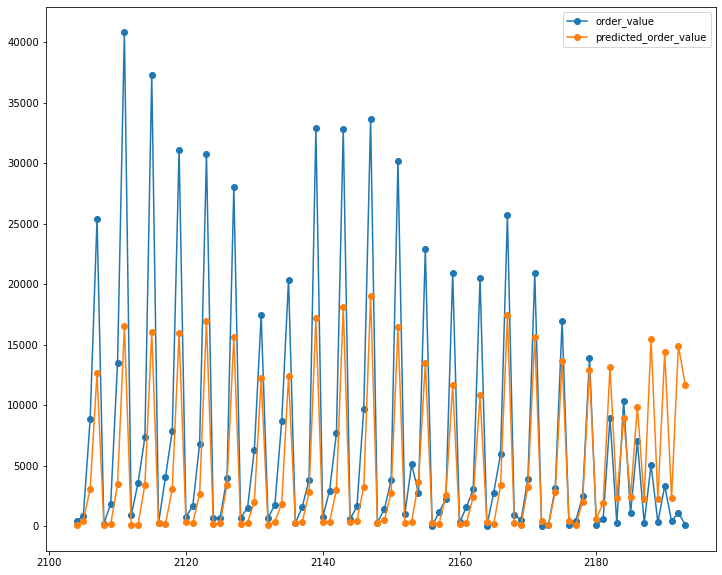

In [104]:
test_with_prediction[["order_value", "predicted_order_value"]].plot(
    figsize=(12, 10), marker="o"
)

<AxesSubplot:>

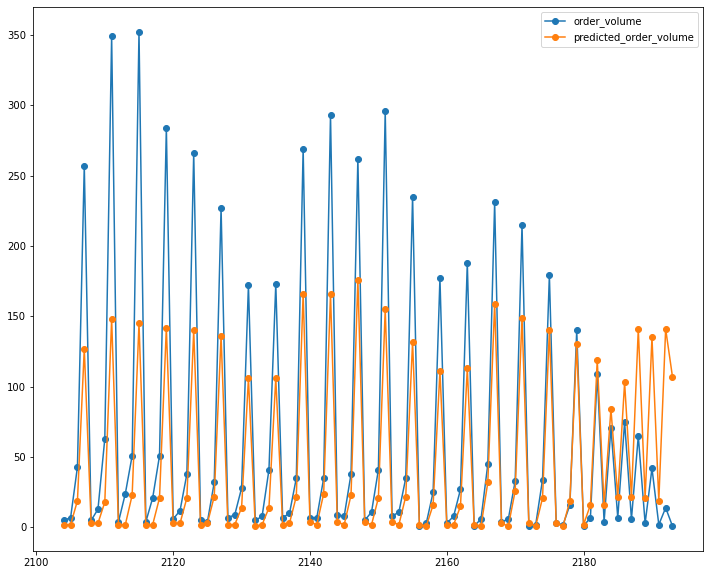

In [105]:
test_with_prediction[["order_volume", "predicted_order_volume"]].plot(
    figsize=(12, 10), marker="o"
)

### Prediction per region

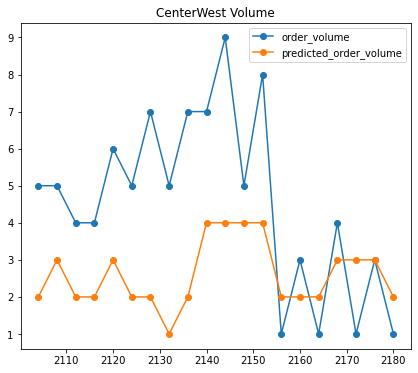

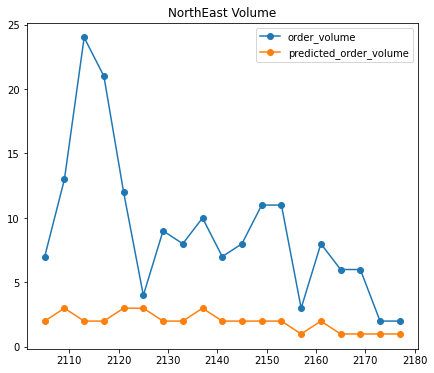

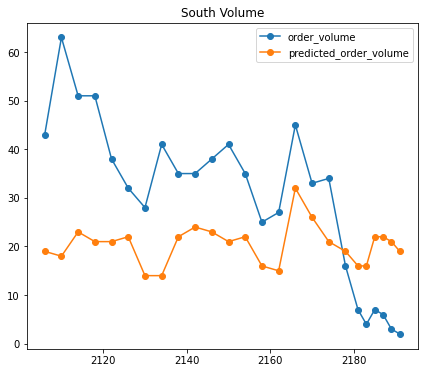

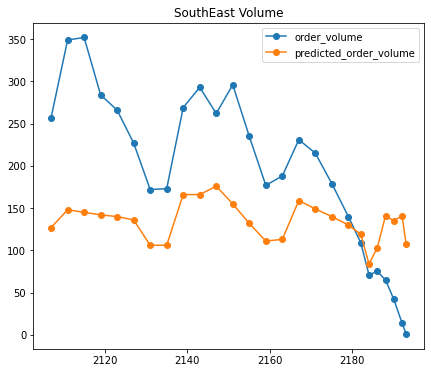

In [106]:
for x in test_with_prediction.region.unique():
    test_with_prediction[test_with_prediction.region == x][
        ["order_volume", "predicted_order_volume"]
    ].plot(title=x + " Volume", marker="o", figsize=(7, 6))

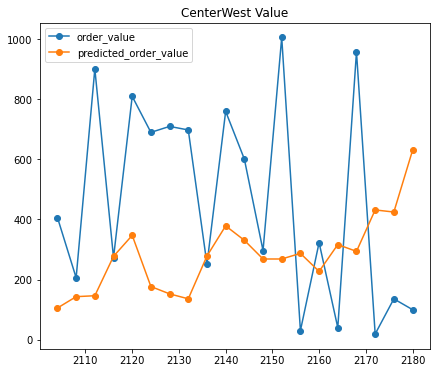

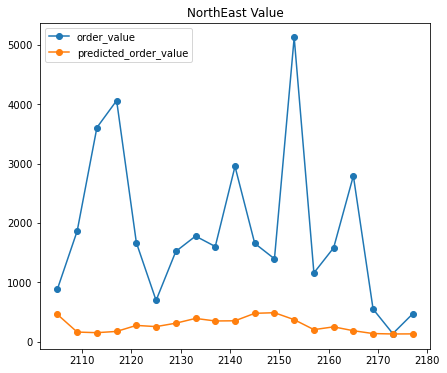

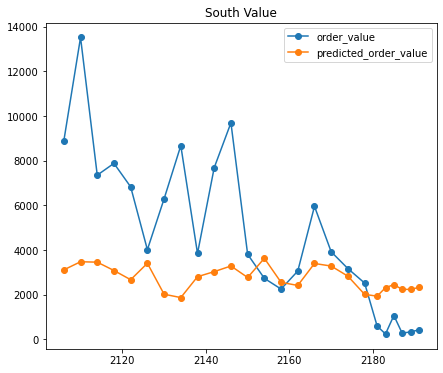

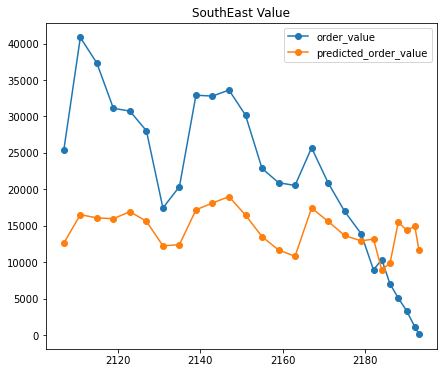

In [107]:
for x in test_with_prediction.region.unique():
    test_with_prediction[test_with_prediction.region == x][
        ["order_value", "predicted_order_value"]
    ].plot(title=x + " Value", marker="o", figsize=(7, 6))

In [108]:
training.region.value_counts()


South         587
SouthEast     587
CenterWest    482
NorthEast     423
North          25
Name: region, dtype: int64

In [109]:
test.region.value_counts()


SouthEast     26
South         25
CenterWest    20
NorthEast     19
North          0
Name: region, dtype: int64

### Creating the Daily Total Order Value and Volume Predictions

In [110]:
classical_ml_time_series_prediction = (
    test_with_prediction[
        [
            "order_date",
            "order_volume",
            "predicted_order_volume",
            "order_value",
            "predicted_order_value",
        ]
    ]
    .groupby("order_date")
    .sum()
)

classical_ml_time_series_prediction

,order_volume,predicted_order_volume,order_value,predicted_order_value
order_date,,,,
2018-08-05,312,150.0,35583.76,16296.63
2018-08-06,430,172.0,56427.39,20294.16
2018-08-07,431,172.0,49178.98,19831.33
2018-08-08,360,167.0,43333.07,19493.79
2018-08-09,322,167.0,40040.28,20218.21
2018-08-10,268,163.0,33424.73,19446.21
2018-08-11,216,124.0,25960.93,14717.61
2018-08-12,227,123.0,31524.21,14797.71
2018-08-13,321,193.0,38613.13,20612.74


In [111]:
classical_ml_time_series_prediction = (
    test_with_prediction[
        [
            "order_date",
            "order_volume",
            "predicted_order_volume",
            "order_value",
            "predicted_order_value",
        ]
    ]
    .groupby("order_date")
    .sum()
)

classical_ml_time_series_prediction["perc_order_volume_deviation"] = (
    np.abs(
        (
            classical_ml_time_series_prediction["order_volume"]
            - classical_ml_time_series_prediction["predicted_order_volume"]
        )
        / classical_ml_time_series_prediction["order_volume"]
    )
    * 100
)
classical_ml_time_series_prediction["perc_order_value_deviation"] = (
    np.abs(
        (
            classical_ml_time_series_prediction["order_value"]
            - classical_ml_time_series_prediction["predicted_order_value"]
        )
        / classical_ml_time_series_prediction["order_value"]
    )
    * 100
)

classical_ml_time_series_prediction["perc_order_value_deviation"] = np.round(
    classical_ml_time_series_prediction["perc_order_value_deviation"], 2
)

classical_ml_time_series_prediction["perc_order_volume_deviation"] = np.round(
    classical_ml_time_series_prediction["perc_order_volume_deviation"], 0
)

In [112]:
classical_ml_time_series_prediction

,order_volume,predicted_order_volume,order_value,predicted_order_value,perc_order_volume_deviation,perc_order_value_deviation
order_date,,,,,,
2018-08-05,312,150.0,35583.76,16296.63,52.0,54.20
2018-08-06,430,172.0,56427.39,20294.16,60.0,64.03
2018-08-07,431,172.0,49178.98,19831.33,60.0,59.68
2018-08-08,360,167.0,43333.07,19493.79,54.0,55.01
2018-08-09,322,167.0,40040.28,20218.21,48.0,49.51
2018-08-10,268,163.0,33424.73,19446.21,39.0,41.82
2018-08-11,216,124.0,25960.93,14717.61,43.0,43.31
2018-08-12,227,123.0,31524.21,14797.71,46.0,53.06
2018-08-13,321,193.0,38613.13,20612.74,40.0,46.62


<AxesSubplot:title={'center':'% deviation of Forcast from Actual Order Level Value'}, xlabel='order_date'>

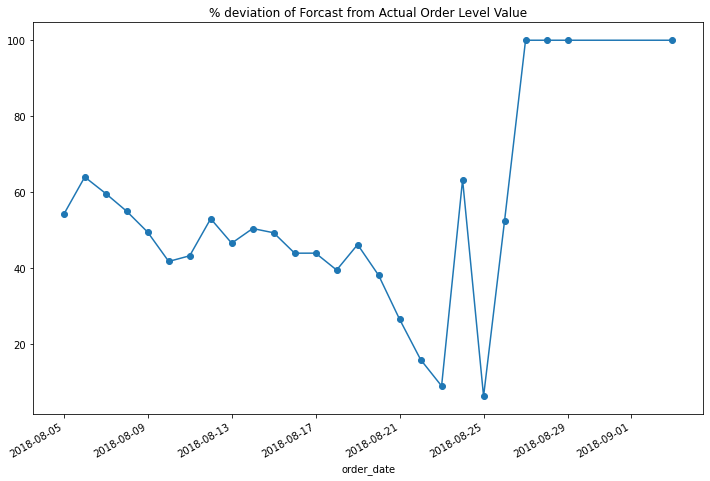

In [113]:
perc_order_value_deviation = (
    classical_ml_time_series_prediction.perc_order_value_deviation.copy()
)

perc_order_value_deviation[perc_order_value_deviation > 100] = 100
perc_order_value_deviation.plot(
    title="% deviation of Forcast from Actual Order Level Value",
    marker="o",
    figsize=(12, 8),
)

<AxesSubplot:title={'center':'% deviation of Forcast from Actual Order Level Volume'}, xlabel='order_date'>

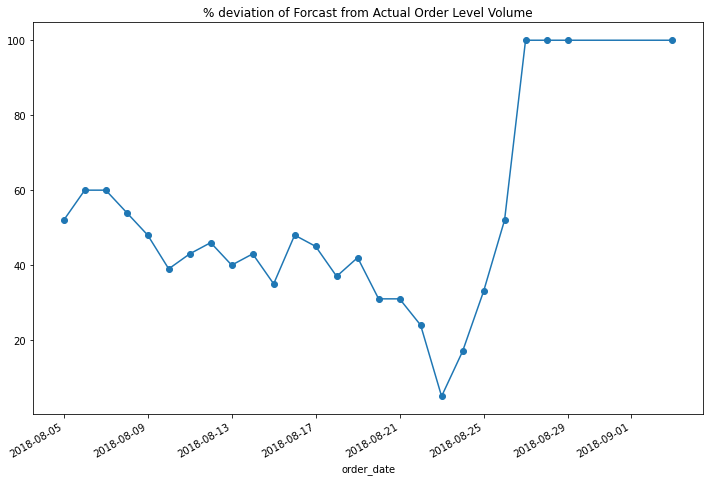

In [114]:
perc_order_volume_deviation = (
    classical_ml_time_series_prediction.perc_order_volume_deviation.copy()
)

perc_order_volume_deviation[perc_order_volume_deviation > 100] = 100
perc_order_volume_deviation.plot(
    title="% deviation of Forcast from Actual Order Level Volume",
    marker="o",
    figsize=(12, 8),
)

In [115]:
# Exporting the prediction result
classical_ml_time_series_prediction.to_csv("classical_ml_time_series_prediction.csv")

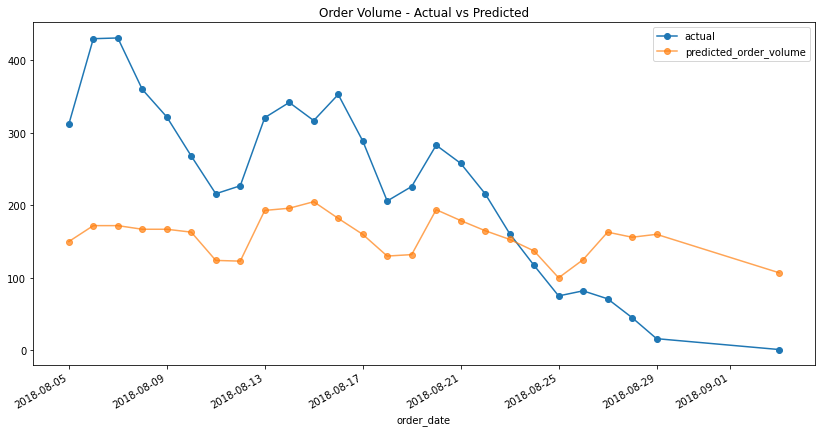

In [116]:

ax = classical_ml_time_series_prediction.order_volume.plot(
    label="actual", figsize=(14, 7), marker="o"
)
classical_ml_time_series_prediction.predicted_order_volume.plot(
    ax=ax,
    title="Order Volume - Actual vs Predicted",
    alpha=0.7,
    figsize=(14, 7),
    marker="o",
)
plt.legend()

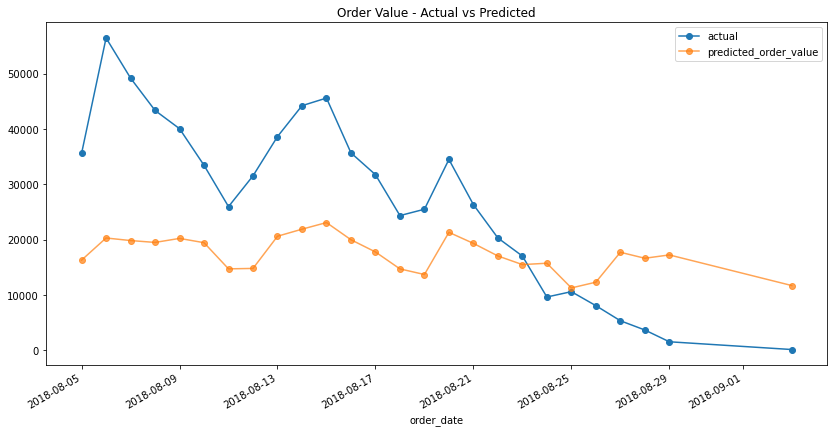

In [117]:
ax = classical_ml_time_series_prediction.order_value.plot(
    label="actual", figsize=(14, 7), marker="o"
)
classical_ml_time_series_prediction.predicted_order_value.plot(
    ax=ax,
    title="Order Value - Actual vs Predicted",
    alpha=0.7,
    figsize=(14, 7),
    marker="o",
)
plt.legend()